In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torchvision
from torchvision import models
from torchvision.models import ResNet18_Weights
import torchvision.transforms as transforms
import torch.utils.model_zoo as model_zoo
from torch.autograd import Variable
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
import torch.nn.init as init
import torch.nn.functional as F



from PIL import Image
import random
import math
from nltk.tokenize import RegexpTokenizer
from collections import defaultdict

from sklearn.model_selection import train_test_split


from torchmetrics.functional import structural_similarity_index_measure
from torch.nn.utils import spectral_norm

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [3]:
from tbos_models import *

In [4]:
IMG_SIZE= 256
BATCH_SIZE=4

ROOT = "/kaggle/input/tbos-dataset"
BBOX_PATH = "/kaggle/input/tbos-dataset/bb_images.txt"

GEN_WTS = "/kaggle/input/tbos-wts/GenWts"
DISC_WTS = "/kaggle/input/tbos-wts/DiscWts"

LR = 2e-4
BETA1 = 0.5
BETA2 = 0.999

NUM_EPOCHS = 7

In [5]:
class BirdsDataset(Dataset):

    def __init__(self, root, split = "train", transformation = None, captions_per_img = 10, bbox_path= None, WORDS_NUM= 20):
        super().__init__()

        self.root= root
        self.split = split
        self.split_dir = os.path.join(root, split)
        self.WORDS_NUM= WORDS_NUM
        self.transform = transformation
        
        self.embeddings_num = captions_per_img

        self.train_filenames= self.get_filenames(self, os.path.join(root, "train"))
        self.test_filenames = self.get_filenames(self, os.path.join(root, "test"))

        self.bboxes = {}
        if bbox_path is not None:
            with open(bbox_path, "r") as file:
                for line in file:
                    parts = line.strip().split()
                    sno = parts[0]
                    fname = parts[1].split("/")[-1]  # Extract filename only
                    coords = list(map(float, parts[2:]))  # Convert x1, x2, y1, y2 to floats
                    self.bboxes[fname] = coords

        self.captions, self.ixtoword, self.wordtoix, self.n_words = self.get_text_data(root, split)

        self.class_to_id = {folder: idx for idx, folder in enumerate(sorted(os.listdir(self.split_dir)))}


    def get_filenames(self, root, split_dir):

        file_names=[]

        for class_folder in sorted(os.listdir(split_dir)):

            for img_name in sorted(os.listdir(os.path.join(split_dir, class_folder))):

                if not img_name.endswith('_rgb.jpg'):
                    file_names.append(os.path.join(class_folder, img_name))

        return file_names
    
    def load_captions(self, root, file_names):
        
        text_dir = os.path.join(root, "text_c10")
        all_captions=[]

        for filename in file_names:
            caps_path = os.path.join(text_dir, filename[:-3]+"txt")

            with open(caps_path, "r") as f:
                captions = f.read().encode('utf-8').decode('utf8').split('\n')

                cnt = 0
                for cap in captions:
                    if len(cap) == 0:
                        continue
                    cap = cap.replace("\ufffd\ufffd", " ")
                    # picks out sequences of alphanumeric characters as tokens
                    # and drops everything else
                    tokenizer = RegexpTokenizer(r'\w+')
                    tokens = tokenizer.tokenize(cap.lower())
                    # print('tokens', tokens)
                    if len(tokens) == 0:
                        print('cap', cap)
                        continue

                    tokens_new = []
                    for t in tokens:
                        t = t.encode('ascii', 'ignore').decode('ascii')
                        if len(t) > 0:
                            tokens_new.append(t)
                    all_captions.append(tokens_new)

                    cnt += 1
                    if cnt == self.embeddings_num:
                        break
                if cnt < self.embeddings_num:
                    print('ERROR: the captions for %s less than %d'
                          % (filename, cnt))
                    
        return all_captions

    def build_dict(self, train_captions, test_captions):

        word_counts = defaultdict(float)

        captions_list = train_captions + test_captions

        for caption in captions_list:
            for word in caption:
                word_counts[word]+=1

        vocab = [w for w in word_counts if word_counts[w] >= 0]

        ### 1 based indexing over vocab-list, 0th index is taken by EOS
        ixtoword = {}
        ixtoword[0] = '<end>'

        wordtoix = {}
        wordtoix['<end>'] = 0

        ix = 1

        for w in vocab:
            wordtoix[w] = ix
            ixtoword[ix] = w
            ix += 1
 
        ###converting ["A", "B", ..] to [1,2,....] using wordtoix, encoding the tokens into numerals
        train_captions_new = []
        for t in train_captions:
            rev = []
            for w in t:
                if w in wordtoix:
                    rev.append(wordtoix[w])
            # rev.append(0)  # do not need '<end>' token
            train_captions_new.append(rev)

        test_captions_new = []
        for t in test_captions:
            rev = []
            for w in t:
                if w in wordtoix:
                    rev.append(wordtoix[w])
            # rev.append(0)  # do not need '<end>' token
            test_captions_new.append(rev)


        ### IN THE ORIGINAL CODE THEY ALSO RETURN TEST_CAPTIONS_TOGETHER
        ### I THINK IT MAKES SENSE, BECAUSE ONLY THEN WOULD THE TRAIN AND TEST VOCABS MATCH
        return [train_captions_new, test_captions_new, ixtoword, wordtoix, len(ixtoword)]

    def get_text_data(self, root, split):

        train_captions = self.load_captions(root, self.train_filenames)
        test_captions = self.load_captions(root, self.test_filenames)

        [train_captions, test_captions, ixtoword, wordtoix, n_words] = self.build_dict(train_captions, test_captions)

        if( split == "train"):
            return  train_captions, ixtoword, wordtoix, n_words
        else:
            return  test_captions, ixtoword, wordtoix, n_words

    def get_img(self, img_path, transform=None, bbox=None):

        img = Image.open(img_path).convert("RGB")
        width, height = img.size

        if bbox is not None:
            r = int(np.maximum(bbox[2], bbox[3]) * 0.75)
            center_x = int((2 * bbox[0] + bbox[2]) / 2)
            center_y = int((2 * bbox[1] + bbox[3]) / 2)
            y1 = np.maximum(0, center_y - r)
            y2 = np.minimum(height, center_y + r)
            x1 = np.maximum(0, center_x - r)
            x2 = np.minimum(width, center_x + r)
            img = img.crop([x1, y1, x2, y2])

        if transform is not None:
            img = transform(img)
        return img  ### IN THE ORIGINAL CODE THEY RETURN AS A LIST BECAUSE THEY'RE USING BRANCHES (BASICALLY DIFFERENT SIZES OF THE SAME IMG) 
    
    def get_caption(self, sent_idx):

        # get caption corresponding to sent_idx
        sent_caption = np.asarray(self.captions[sent_idx]).astype('int64')

        ## If the caption already contains an EOS (0) token
        if (sent_caption == 0).sum() > 0:
            print('ERROR: do not need END (0) token', sent_caption)

        num_words = len(sent_caption)
        # pad with 0s (i.e., '<end>') 
        x = np.zeros((self.WORDS_NUM, 1), dtype='int64')
        x_len = num_words
        if num_words <= self.WORDS_NUM:
            x[:num_words, 0] = sent_caption
        else:
            ix = list(np.arange(num_words))  # 1, 2, 3,..., maxNum
            np.random.shuffle(ix)
            ix = ix[:self.WORDS_NUM]
            ix = np.sort(ix)
            x[:, 0] = sent_caption[ix]
            x_len = self.WORDS_NUM

        # Convert indices back to words
        caption_words = [self.ixtoword[idx] for idx in sent_caption if idx in self.ixtoword]
        caption_text = " ".join(caption_words)        
        
        return x, x_len, caption_text

    def __len__(self):
        if(self.split == "train"):
            return len(self.train_filenames)
        
        return len(self.test_filenames)

    def __getitem__(self, index):
        
        if self.split=="train":
            filename= self.train_filenames[index]
            filepath = os.path.join(self.split_dir,filename)
        else:
            filename = self.test_filenames[index]
            filepath = os.path.join(self.split_dir,filename)

        bbox= self.bboxes[filename.split("/")[-1]]

        image = self.get_img(filepath, self.transform,bbox)

        sentence_idx= random.randint(0, self.embeddings_num-1)
        new_idx = index * self.embeddings_num + sentence_idx

        captions, len_caps, caption_text = self.get_caption(new_idx)

        class_folder = filename.split(os.sep)[0]  # Extract the class folder name
        # print(class_folder, filename )
        class_id = self.class_to_id[class_folder]  # Map class folder to class ID

        return image, captions, len_caps, class_id, caption_text   


In [6]:
def sort_by_caption_lengths(imgs, captions, caption_lengths, cls_ids, caption_texts):
    """
    Sorts the inputs from the dataset in decreasing order of caption lengths.
    
    Args:
        imgs (torch.Tensor): Tensor of images (B, C, H, W).
        captions (torch.Tensor): Tensor of captions (B, max_caption_length).
        caption_lengths (torch.Tensor): Tensor of caption lengths (B).
        cls_ids (torch.Tensor): Tensor of class IDs (B).
        caption_texts (list of str): List of caption strings.
    
    Returns:
        tuple: Sorted (imgs, captions, caption_lengths, cls_ids, caption_texts).
    """
    # Sort the caption lengths in decreasing order
    caption_lengths, sorted_indices = torch.sort(caption_lengths, descending=True)
    
    # Rearrange the inputs to match the sorted indices
    imgs = imgs[sorted_indices]
    captions = captions[sorted_indices]
    cls_ids = cls_ids[sorted_indices]
    caption_texts = [caption_texts[i] for i in sorted_indices.cpu().numpy()]  # For list
    
    return imgs, captions, caption_lengths, cls_ids, caption_texts



def get_data(dataloader):
    
    imgs, captions, cap_lens, class_ids, cap_text = next(iter(dataloader))
    
    sorted_imgs, sorted_captions, sorted_caption_lengths, sorted_cls_ids, sorted_caption_texts = \
        sort_by_caption_lengths(imgs, captions, cap_lens, class_ids, cap_text)

    # print(sorted_caption_lengths)
    if(torch.cuda.is_available()):
        sorted_imgs = sorted_imgs.cuda()
        sorted_captions = sorted_captions.cuda()
        sorted_caption_lengths = sorted_caption_lengths.cuda()
        sorted_cls_ids = sorted_cls_ids.cuda()
        # sorted_caption_texts = sorted_caption_texts.cuda()

    return [sorted_imgs, sorted_captions, sorted_caption_lengths, sorted_cls_ids, sorted_caption_texts]

def get_mask():
        
    mask = []
    IMAGE_SIZE = IMG_SIZE
    
    for i in range(BATCH_SIZE):
        
        q1 = p1 = IMG_SIZE // 4
        q2 = p2 = IMG_SIZE - IMG_SIZE // 4
            
        m = np.zeros((IMG_SIZE, IMG_SIZE), dtype=np.uint8)
        m[q1:q2 + 1, p1:p2 + 1] = 1
        m = np.expand_dims(m, 0)
        mask.append(m)
            
    mask = np.array(mask)
    mask = torch.from_numpy(mask)

    if torch.cuda.is_available():
        mask = mask.float().cuda()
    return mask

In [7]:
train_tf = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor()
])

In [8]:
dataset = BirdsDataset(root = ROOT, split= "train", bbox_path = BBOX_PATH, transformation = train_tf)
dataloader = DataLoader(dataset,batch_size=BATCH_SIZE,shuffle=True,drop_last=True)

## PreTrained

In [9]:
image_encoder = CNN_ENCODER(IMG_SIZE)

img_encoder_path = "/kaggle/input/damsm_pretrained/pytorch/default/1/bird/image_encoder200.pth"
state_dict = torch.load(img_encoder_path, map_location=lambda storage, loc: storage)
image_encoder.load_state_dict(state_dict)
for p in image_encoder.parameters():
    p.requires_grad = False
print('Load image encoder from:', img_encoder_path)
image_encoder.eval()

/usr/local/lib/python3.10/dist-packages/torchvision/models/inception.py:43: FutureWarning: The default weight initialization of inception_v3 will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  warnings.warn(
Downloading: "https://download.pytorch.org/models/inception_v3_google-1a9a5a14.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-1a9a5a14.pth
100%|██████████| 104M/104M [00:00<00:00, 395MB/s] 
<ipython-input-9-8b6ced34ed97>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be fli

Load pretrained model from  https://download.pytorch.org/models/inception_v3_google-1a9a5a14.pth
Load image encoder from: /kaggle/input/damsm_pretrained/pytorch/default/1/bird/image_encoder200.pth


CNN_ENCODER(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, 

In [10]:
text_encoder = RNN_ENCODER(dataset.n_words, nhidden=IMG_SIZE)

text_encoder_path = "/kaggle/input/damsm_pretrained/pytorch/default/1/bird/text_encoder200.pth"
state_dict = torch.load(text_encoder_path, map_location=lambda storage, loc: storage)
text_encoder.load_state_dict(state_dict)
for p in text_encoder.parameters():
    p.requires_grad = False
print('Load text encoder from:', text_encoder_path)
text_encoder.eval()

Load text encoder from: /kaggle/input/damsm_pretrained/pytorch/default/1/bird/text_encoder200.pth


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn(
<ipython-input-10-a7b35b7d11c1>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=

RNN_ENCODER(
  (encoder): Embedding(5450, 300)
  (drop): Dropout(p=0.5, inplace=False)
  (rnn): LSTM(300, 128, batch_first=True, dropout=0.5, bidirectional=True)
)

## Inpaint Net

### CoarseNet

In [11]:
class CoarseNet(nn.Module):

    def __init__(self, c_img=3,
                 norm='instance', act_en='leaky_relu', act_de='relu'):#instance normalisation is being there!

        super().__init__()
        #initially number of channels is 64 
        cnum = 64
        #Layer 1 
        self.en_1 = nn.Conv2d(c_img, cnum, 4,2,padding = 1)
        self.en_2 = CoarseEncodeBlock(cnum, cnum*2, 4, 2, normalization = norm, activation = act_en)
        self.en_3 = CoarseEncodeBlock(cnum*2, cnum*4, 4, 2, normalization=norm, activation=act_en)
        self.en_4 = CoarseEncodeBlock(cnum*4, cnum*8, 4, 2, normalization=norm, activation=act_en)
        self.en_5 = CoarseEncodeBlock(cnum*16, cnum*8, 4, 2, normalization=norm, activation=act_en)
        self.en_6 = CoarseEncodeBlock(cnum*8, cnum*8, 4, 2, normalization=norm, activation=act_en)
        self.en_7 = CoarseEncodeBlock(cnum*8, cnum*8, 4, 2, normalization=norm, activation=act_en)
        self.en_8 = CoarseEncodeBlock(cnum*8, cnum*8, 4, 2, activation=act_en)


        # Defining the decoder layers
        self.de_8 = CoarseDecodeBlock(cnum*8, cnum*8, 3, 2, normalization=norm, activation=act_de)
        self.de_7 = CoarseDecodeBlock(cnum*8*2, cnum*8, 3, 2, normalization=norm, activation=act_de)
        self.de_6 = CoarseDecodeBlock(cnum*8*2, cnum*8, 3, 2, normalization=norm, activation=act_de)
        self.de_5 = CoarseDecodeBlock(cnum*8*2, cnum*8, 3, 2, normalization=norm, activation=act_de)
        self.de_4 = CoarseDecodeBlock(cnum*8*2, cnum*4, 3, 2, normalization=norm, activation=act_de)
        self.de_3 = CoarseDecodeBlock(cnum*4*2, cnum*2, 3, 2, normalization=norm, activation=act_de)
        self.de_2 = CoarseDecodeBlock(cnum*2*2, cnum, 3, 2, normalization=norm, activation=act_de)
        self.de_1 = nn.Sequential(
            get_act(act_de),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
            nn.Conv2d(cnum*2, c_img, 3, padding=1),
            get_act('tanh')
        )


        self.ca_net = CA_NET()
        self.h_net1 = INIT_STAGE_G(512, 100)
        self.h_net2 = NEXT_STAGE_G(32, 256, 100)
        self.h_net3 = NEXT_STAGE_G(32, 256, 100)
        self.attn = SelfAttention(512)
        
        self.text_en_1 = nn.Conv2d(32, cnum, 4, 2, padding=1)
        self.text_en_2 = CoarseEncodeBlock(cnum, cnum*2, 4, 2, normalization=norm, activation=act_en)
        self.text_en_3 = CoarseEncodeBlock(cnum*2, cnum*4, 4, 2, normalization=norm, activation=act_en)
        self.text_en_4 = CoarseEncodeBlock(cnum*4, cnum*8, 4, 2, normalization=norm, activation=act_en)


    # def forward(self, x, z_code, sent_emb, word_embs, text_mask):

    def forward(self, x, z_code, sent_emb, word_embs, text_mask):
        
        ################## Image Encoder 1 ###################
        out_1 = self.en_1(x)
        out_2 = self.en_2(out_1)
        out_3 = self.en_3(out_2)
        out_4 = self.en_4(out_3)
        # print("out 4", out_4.shape)
        
        #################### Attention ######################
        attn_feature = self.attn(out_4, word_embs)

        # print("IMAGE ADAPTIVE", attn_feature.shape)
                
        ################## Text 2 Image ######################

        
        att_maps = []
        c_code, mu, logvar = self.ca_net(sent_emb) 
        # print("CA NET", c_code.shape)

        h_code1 = self.h_net1(z_code, c_code)
        # print("HNET1", h_code1.shape)

        h_code2, att1 = self.h_net2(h_code1, c_code, word_embs, text_mask) 
        # print("HNET2", h_code2.shape, att1.shape)
        if att1 is not None:
            att_maps.append(att1)   
        h_code3, att2 = self.h_net3(h_code2, c_code, attn_feature, text_mask)
        # print("HNET 3", h_code3.shape, att2.shape)
        if att2 is not None:
            att_maps.append(att2)
            
        # ################## Text-Image Encoder #################

        
        text_out_1 = self.text_en_1(h_code3)
        text_out_2 = self.text_en_2(text_out_1)
        text_out_3 = self.text_en_3(text_out_2)
        text_out_4 = self.text_en_4(text_out_3)


        # ###RANDOM CHECKING
        # req_shape = out_4.shape
        # text_out_4 = torch.randn(req_shape).to(device)
        # att1 = torch.randn((4, 15, 64, 64)).to(device)
        # att2 = torch.randn((4,15,128,128)).to(device)
        # print(text_out_4.shape)
        ################## Image Encoder 2 ###################
        
        out_4_t = torch.cat([out_4 , text_out_4], 1)

        # print("concatenated", out_4_t.shape)

        out_5 = self.en_5(out_4_t)
        out_6 = self.en_6(out_5)
        out_7 = self.en_7(out_6)
        out_8 = self.en_8(out_7)
        
        ##################### Decoder #########################
        # print(out_8.shape)
        dout_8 = self.de_8(out_8)
        dout_8_out_7 = torch.cat([dout_8, out_7], 1)
        dout_7 = self.de_7(dout_8_out_7)
        dout_7_out_6 = torch.cat([dout_7, out_6], 1)
        dout_6 = self.de_6(dout_7_out_6)
        dout_6_out_5 = torch.cat([dout_6, out_5], 1)
        dout_5 = self.de_5(dout_6_out_5)
        dout_5_out_4 = torch.cat([dout_5, out_4], 1)
        dout_4 = self.de_4(dout_5_out_4)
        dout_4_out_3 = torch.cat([dout_4, out_3], 1)
        dout_3 = self.de_3(dout_4_out_3)
        dout_3_out_2 = torch.cat([dout_3, out_2], 1)
        dout_2 = self.de_2(dout_3_out_2)
        dout_2_out_1 = torch.cat([dout_2, out_1], 1)
        dout_1 = self.de_1(dout_2_out_1)
       
        # return dout_1, att1, att2

        return dout_1, att1, att2


### RefineNet

In [12]:
class RefineNet(nn.Module):
    def __init__(self, c_img=3,
                 norm='instance', act_en='leaky_relu', act_de='relu'):
        super().__init__()

        c_in = c_img + c_img
        cnum = 64

        self.en_1 = nn.Conv2d(c_in, cnum, 3, 1, padding=1)
        self.en_2 = RefineEncodeBlock(cnum, cnum*2, normalization=norm, activation=act_en)
        self.en_3 = RefineEncodeBlock(cnum*2, cnum*4, normalization=norm, activation=act_en)
        self.en_4 = RefineEncodeBlock(cnum*4, cnum*8, normalization=norm, activation=act_en)
        self.en_5 = RefineEncodeBlock(cnum*8, cnum*8, normalization=norm, activation=act_en)
        self.en_6 = RefineEncodeBlock(cnum*8, cnum*8, normalization=norm, activation=act_en)
        self.en_7 = RefineEncodeBlock(cnum*8, cnum*8, normalization=norm, activation=act_en)
        self.en_8 = RefineEncodeBlock(cnum*8, cnum*8, normalization=norm, activation=act_en)
        self.en_9 = nn.Sequential(
            get_act(act_en),
            nn.Conv2d(cnum*8, cnum*8, 4, 2, padding=1))

        self.de_9 = nn.Sequential(
                get_act(act_de),
                nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
                nn.Conv2d(cnum*8, cnum*8, 3, padding=1),
                get_norm(norm, cnum*8))
        self.de_8 = RefineDecodeBlock(cnum*8*2, cnum*8, normalization=norm, activation=act_de)
        self.de_7 = RefineDecodeBlock(cnum*8*2, cnum*8, normalization=norm, activation=act_de)
        self.de_6 = RefineDecodeBlock(cnum*8*2, cnum*8, normalization=norm, activation=act_de)
        self.de_5 = RefineDecodeBlock(cnum*8*2, cnum*8, normalization=norm, activation=act_de)
        self.de_4 = RefineDecodeBlock(cnum*8*2, cnum*4, normalization=norm, activation=act_de)
        self.de_3 = RefineDecodeBlock(cnum*4*2, cnum*2, normalization=norm, activation=act_de)
        self.de_2 = RefineDecodeBlock(cnum*2*2, cnum, normalization=norm, activation=act_de)
        self.de_1 = nn.Sequential(
                    get_act(act_de),
                    # nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
                    nn.Conv2d(cnum*2, c_img, 3, padding=1),
                    
                )

    def forward(self, x1, x2):
        x = torch.cat([x1, x2], 1)
        out_1 = self.en_1(x)
        out_2 = self.en_2(out_1)
        out_3 = self.en_3(out_2)
        out_4 = self.en_4(out_3)
        out_5 = self.en_5(out_4)
        out_6 = self.en_6(out_5)
        out_7 = self.en_7(out_6)
        out_8 = self.en_8(out_7)
        out_9 = self.en_9(out_8)

        dout_9 = self.de_9(out_9)
        dout_9_out_8 = torch.cat([dout_9, out_8], 1)
        dout_8 = self.de_8(dout_9_out_8)
        dout_8_out_7 = torch.cat([dout_8, out_7], 1)
        dout_7 = self.de_7(dout_8_out_7)
        dout_7_out_6 = torch.cat([dout_7, out_6], 1)
        dout_6 = self.de_6(dout_7_out_6)
        dout_6_out_5 = torch.cat([dout_6, out_5], 1)
        dout_5 = self.de_5(dout_6_out_5)
        dout_5_out_4 = torch.cat([dout_5, out_4], 1)
        dout_4 = self.de_4(dout_5_out_4)
        dout_4_out_3 = torch.cat([dout_4, out_3], 1)
        dout_3 = self.de_3(dout_4_out_3)
        dout_3_out_2 = torch.cat([dout_3, out_2], 1)
        dout_2 = self.de_2(dout_3_out_2)
        dout_2_out_1 = torch.cat([dout_2, out_1], 1)
        dout_1 = self.de_1(dout_2_out_1)

        return dout_1

### Inpaint Net

In [13]:
class InpaintNet(nn.Module):
    def __init__(self):
        super().__init__()

        self.coarse_t = CoarseNet()
        self.refine_t = RefineNet()
        
        self.weight_conv = nn.Conv2d(16, 1, 3, 1, padding=1)
        self.weight_up = nn.Upsample(scale_factor=2, mode='nearest', align_corners=None)

    def forward(self, image, mask, z_code, sent_emb, word_embs, text_mask):

        out_c_t, att1, att2 = self.coarse_t(image, z_code, sent_emb, word_embs, text_mask)
        out_c_t = image * (1. - mask) + out_c_t * mask

        out_r_t = self.refine_t(out_c_t, image)
        out_r_t = image * (1. - mask) + out_r_t * mask
        
        attn_loss_add = torch.zeros_like(att2,dtype=torch.float)
        attn_loss_add = torch.cat([att2, attn_loss_add, attn_loss_add, attn_loss_add], 1)  
        attn_loss_add = attn_loss_add[:, :16, :, :]   ### THESE LAST THREE LINES SEEM USELESS, COULDVE MAYBE DIRECTLY PASSED ATT2, JUST ENSURE N_CHANNELS=16
        attn_loss = self.weight_conv(attn_loss_add)
        attn_loss = self.weight_up(attn_loss)

        return out_c_t, out_r_t, attn_loss

## Patch Discriminator

In [14]:
class PatchDiscriminator(nn.Module):
    def __init__(self, c_img=3,
                 norm='instance', act='leaky_relu'):
        super().__init__()

        c_in = c_img + c_img
        cnum = 64
        self.discriminator = nn.Sequential(
            nn.Conv2d(c_in, cnum, 4, 2, 1),
            get_act(act),

            nn.Conv2d(cnum, cnum*2, 4, 2, 1),
            get_norm(norm, cnum*2),
            get_act(act),

            nn.Conv2d(cnum*2, cnum*4, 4, 2, 1),
            get_norm(norm, cnum*4),
            get_act(act),

            nn.Conv2d(cnum*4, cnum*8, 4, 1, 1),
            get_norm(norm, cnum*8),
            get_act(act),

            nn.Conv2d(cnum*8, 1, 4, 1, 1))
    
    def forward(self, x1, x2):
        x = torch.cat([x1, x2], 1)
        return self.discriminator(x)

## Loss

In [15]:

def func_attention(query, context, gamma1):
    """
    query: batch x ndf x queryL
    context: batch x ndf x ih x iw (sourceL=ihxiw)
    mask: batch_size x sourceL
    """
    batch_size, queryL = query.size(0), query.size(2)
    ih, iw = context.size(2), context.size(3)
    sourceL = ih * iw

    # --> batch x sourceL x ndf
    context = context.view(batch_size, -1, sourceL)
    contextT = torch.transpose(context, 1, 2).contiguous()

    # Get attention
    # (batch x sourceL x ndf)(batch x ndf x queryL)
    # -->batch x sourceL x queryL
    attn = torch.bmm(contextT, query) # Eq. (7) in AttnGAN paper
    # --> batch*sourceL x queryL
    attn = attn.view(batch_size*sourceL, queryL)
    attn = nn.Softmax()(attn)  # Eq. (8)

    # --> batch x sourceL x queryL
    attn = attn.view(batch_size, sourceL, queryL)
    # --> batch*queryL x sourceL
    attn = torch.transpose(attn, 1, 2).contiguous()
    attn = attn.view(batch_size*queryL, sourceL)
    #  Eq. (9)
    attn = attn * gamma1
    attn = nn.Softmax()(attn)
    attn = attn.view(batch_size, queryL, sourceL)
    # --> batch x sourceL x queryL
    attnT = torch.transpose(attn, 1, 2).contiguous()

    # (batch x ndf x sourceL)(batch x sourceL x queryL)
    # --> batch x ndf x queryL
    weightedContext = torch.bmm(context, attnT)

    return weightedContext, attn.clone().view(batch_size, -1, ih, iw)


In [16]:
def calc_gan_loss(discriminator, output, target):
    y_pred_fake = discriminator(output, target)
    y_pred = discriminator(target, output)

    g_loss = (torch.mean((y_pred - torch.mean(y_pred_fake) + 1.) ** 2) + torch.mean((y_pred_fake - torch.mean(y_pred) - 1.) ** 2))/2
    d_loss = (torch.mean((y_pred - torch.mean(y_pred_fake) - 1.) ** 2) + torch.mean((y_pred_fake - torch.mean(y_pred) + 1.) ** 2))/2

    return g_loss, d_loss

def cosine_similarity(x1, x2, dim=1, eps=1e-8):
    w12 = torch.sum(x1 * x2, dim)
    w1 = torch.norm(x1, 2, dim)
    w2 = torch.norm(x2, 2, dim)

    res = (w12 / (w1 * w2).clamp(min=eps)).squeeze()
    return res

def sent_loss(cnn_code, rnn_code, labels, class_ids, batch_size, use_cuda=True, eps=1e-8):
    # ### Mask mis-match samples ###
    # that come from the same class as the real sample ###
    masks = []
    if class_ids is not None:
        for i in range(batch_size):
            mask = (class_ids == class_ids[i]).cpu().numpy().astype(np.uint8)
            mask[i] = 0
            masks.append(mask.reshape((1, -1)))
        masks = np.concatenate(masks, 0)
        masks = torch.ByteTensor(masks)
        if use_cuda:
            masks = masks.cuda()

    if cnn_code.dim() == 2:
        cnn_code = cnn_code.unsqueeze(0)
        rnn_code = rnn_code.unsqueeze(0)

    cnn_code_norm = torch.norm(cnn_code, 2, dim=2, keepdim=True)
    rnn_code_norm = torch.norm(rnn_code, 2, dim=2, keepdim=True)

    scores0 = torch.bmm(cnn_code, rnn_code.transpose(1, 2))
    norm0 = torch.bmm(cnn_code_norm, rnn_code_norm.transpose(1, 2))
    scores0 = scores0 / norm0.clamp(min=eps) * 10.0

    scores0 = scores0.squeeze()
    if class_ids is not None:
        scores0 = scores0.masked_fill(masks.bool(), -float('inf'))  # Removed in-place operation
    scores1 = scores0.transpose(0, 1)
    
    if labels is not None:
        loss0 = nn.CrossEntropyLoss()(scores0, labels)
        loss1 = nn.CrossEntropyLoss()(scores1, labels)
    else:
        loss0, loss1 = None, None
    return loss0, loss1

def words_loss(img_features, words_emb, labels, cap_lens, class_ids, batch_size, use_cuda=True):
    masks = []
    att_maps = []
    similarities = []
    cap_lens = cap_lens.data.tolist()
    
    for i in range(batch_size):
        if class_ids is not None:
            mask = (class_ids == class_ids[i]).byte()
            mask[i] = 0
            masks.append(mask.reshape((1, -1)))
        
        words_num = cap_lens[i]
        word = words_emb[i, :, :words_num].unsqueeze(0).contiguous()
        word = word.repeat(batch_size, 1, 1)
        context = img_features
        
        weiContext, attn = func_attention(word, context, 5.0)
        att_maps.append(attn[i].unsqueeze(0).contiguous())
        
        word = word.transpose(1, 2).contiguous()
        weiContext = weiContext.transpose(1, 2).contiguous()
        
        word = word.view(batch_size * words_num, -1)
        weiContext = weiContext.view(batch_size * words_num, -1)
        
        row_sim = cosine_similarity(word, weiContext)
        row_sim = row_sim.view(batch_size, words_num)

        # Removed in-place operations here
        row_sim = row_sim * 5.0
        row_sim = row_sim.exp()
        row_sim = row_sim.sum(dim=1, keepdim=True)
        row_sim = torch.log(row_sim)

        similarities.append(row_sim)

    similarities = torch.cat(similarities, 1)
    if class_ids is not None:
        masks = torch.cat(masks, 0)
        masks = masks.byte()
        if use_cuda:
            masks = masks.cuda()
    
    similarities = similarities * 10.0
    if class_ids is not None:
        similarities = similarities.masked_fill(masks.bool(), -float('inf'))  # Removed in-place operation
    similarities1 = similarities.transpose(0, 1)
    
    if labels is not None:
        loss0 = nn.CrossEntropyLoss()(similarities, labels)
        loss1 = nn.CrossEntropyLoss()(similarities1, labels)
    else:
        loss0, loss1 = None, None
    return loss0, loss1, att_maps

L1Loss = nn.L1Loss().to(device)

In [17]:
def get_recon_loss(mask, imgs, result, L1Loss): #, rate_for_mask_loss=0.8
    
    # Ensure mask is a binary mask (0 and 1 values)
    
    unmasked_area = imgs * (1. - mask)   # Isolating the unmasked region of the original image
    masked_area = imgs - unmasked_area   # Isolating the masked region of the original image
    
    unmasked_result = result * (1. - mask)  # Isolating the unmasked region of the result image
    masked_result = result - unmasked_result  # Isolating the masked region of the result image
    
    # Compute L1 loss for both the unmasked and masked regions
    # unmasked_loss = L1Loss(unmasked_result, unmasked_area)  # L1 loss for unmasked region
    masked_loss = L1Loss(masked_result, masked_area)  # L1 loss for masked region

    return masked_loss
    
    # Total loss is the weighted sum of the unmasked and masked losses
    # tot_loss = (unmasked_loss * (1 - rate_for_mask_loss)) + (masked_loss * rate_for_mask_loss)
    
    # return tot_loss

## Training

In [18]:
def prepare_labels():
    batch_size = BATCH_SIZE
    real_labels = Variable(torch.FloatTensor(batch_size).fill_(1))
    fake_labels = Variable(torch.FloatTensor(batch_size).fill_(0))
    match_labels = Variable(torch.LongTensor(range(batch_size)))
    if torch.cuda.is_available():
        real_labels = real_labels.cuda()
        fake_labels = fake_labels.cuda()
        match_labels = match_labels.cuda()

    return real_labels, fake_labels, match_labels
    
real_labels, fake_labels, match_labels = prepare_labels()

In [19]:
len(dataloader)

2352

In [20]:
g_model = InpaintNet().to(device)
d_model = PatchDiscriminator().to(device)

image_encoder = image_encoder.to(device)
text_encoder = text_encoder.to(device)

In [21]:
gen_state_dict = torch.load(GEN_WTS, map_location=lambda storage, loc: storage)
g_model.load_state_dict(gen_state_dict)

<ipython-input-21-d8496843755d>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  gen_state_dict = torch.load(GEN_WTS, map_location=lambda storage, loc: storage)


<All keys matched successfully>

In [22]:
disc_state_dict = torch.load(DISC_WTS, map_location=lambda storage, loc: storage)
d_model.load_state_dict(disc_state_dict)

<ipython-input-22-1e4720eeeb18>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  disc_state_dict = torch.load(DISC_WTS, map_location=lambda storage, loc: storage)


<All keys matched successfully>

In [23]:
g_model.refine_t.de_9, g_model.refine_t.de_8, g_model.refine_t.de_1

(Sequential(
   (0): ReLU(inplace=True)
   (1): Upsample(scale_factor=2.0, mode='bilinear')
   (2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
   (3): InstanceNorm2d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
 ),
 RefineDecodeBlock(
   (decode): Sequential(
     (0): ReLU(inplace=True)
     (1): Upsample(scale_factor=2.0, mode='bilinear')
     (2): Conv2d(1024, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (3): InstanceNorm2d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
     (4): ReLU(inplace=True)
     (5): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (6): InstanceNorm2d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
   )
 ),
 Sequential(
   (0): ReLU(inplace=True)
   (1): Conv2d(128, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
 ))

In [24]:
# masked_img = torch.randn((4,3,256,256)).to(device)
# z_code = torch.randn((4,100)).to(device)
# word_embs = torch.randn((4,256,15)).to(device)
# sent_emb = torch.randn((4,256)).to(device)

# text_mask = torch.randint(0, 2, (4, 15, 1), dtype=torch.bool).to(device)
# sample_mask = get_mask().to(device)

# coarse_result_t, refine_result_t, attn_loss = g_model(masked_img, sample_mask, z_code, sent_emb, word_embs, text_mask)

# coarse_result_t.shape, refine_result_t.shape, attn_loss.shape

In [25]:
g_optimizer = torch.optim.Adam(
    g_model.parameters(),
    LR, (BETA1, BETA2))


d_optimizer = torch.optim.Adam(
    d_model.parameters(),
    LR, (BETA1, BETA2))

In [26]:
nz = 100
noise = Variable(torch.FloatTensor(BATCH_SIZE, nz)) ### DEFINED, BUT NOT INITIALIZED

if torch.cuda.is_available():
    noise.cuda()

In [27]:
torch.autograd.set_detect_anomaly(True)

/kaggle/usr/lib/tbos_models/tbos_models.py:287: UserWarning: The torch.cuda.*DtypeTensor constructors are no longer recommended. It's best to use methods such as torch.tensor(data, dtype=*, device='cuda') to create tensors. (Triggered internally at ../torch/csrc/tensor/python_tensor.cpp:78.)
  eps = torch.cuda.FloatTensor(std.size()).normal_()
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/instancenorm.py:115: UserWarning: input's size at dim=1 does not match num_features. You can silence this warning by not passing in num_features, which is not used because affine=False
  warnings.warn(



Epoch 0/7
Batch 0/2352
TIM=8.15512752532959, RECON=0.05772720277309418, GAN_LOSS= 4.0806355476379395, TOTAL=0.07404360175132751


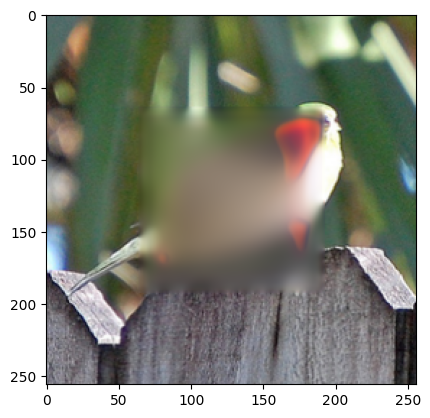

###################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################
Epoch 0/7
Batch 500/2352
TIM=8.904624938964844, RECON=0.05427217110991478, GAN_LOSS= 3.995290756225586, TOTAL=0.07116737961769104


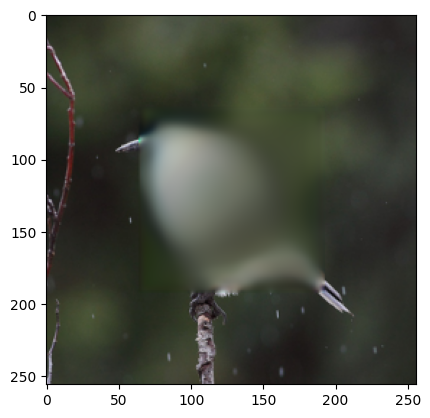

###################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################
Epoch 0/7
Batch 1000/2352
TIM=6.953031063079834, RECON=0.03972639515995979, GAN_LOSS= 4.016568660736084, TOTAL=0.05471256375312805


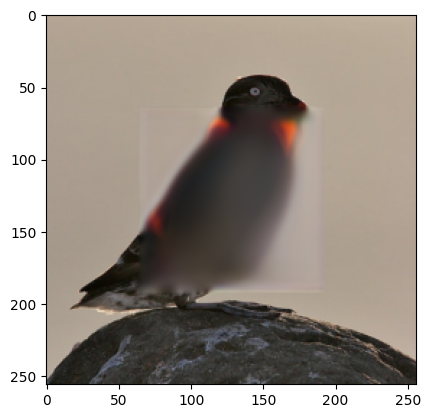

###################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################
Epoch 0/7
Batch 1500/2352
TIM=5.745294094085693, RECON=0.05314216390252113, GAN_LOSS= 3.986575126647949, TOTAL=0.0668606087565422


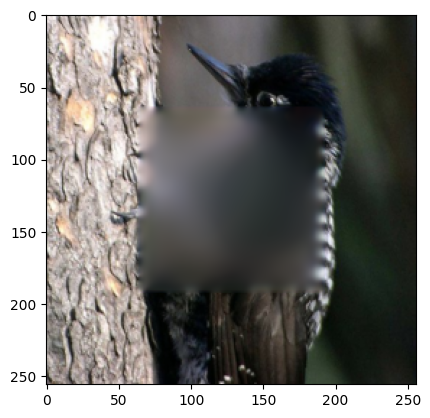

###################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################
Epoch 0/7
Batch 2000/2352
TIM=5.3271164894104, RECON=0.05370279774069786, GAN_LOSS= 3.9988012313842773, TOTAL=0.0670275166630745


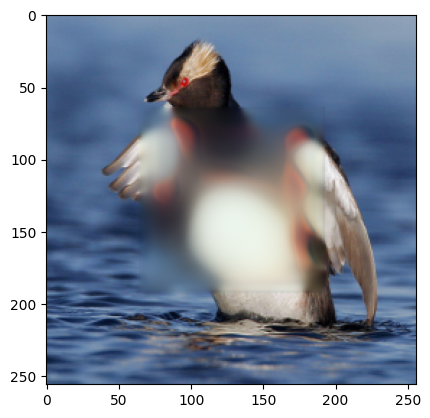

###############################################################################################################################################################################################################################################################################################################################################################
Epoch 1/7
Batch 0/2352
TIM=7.054960250854492, RECON=0.03991507738828659, GAN_LOSS= 4.000985622406006, TOTAL=0.05497201159596443


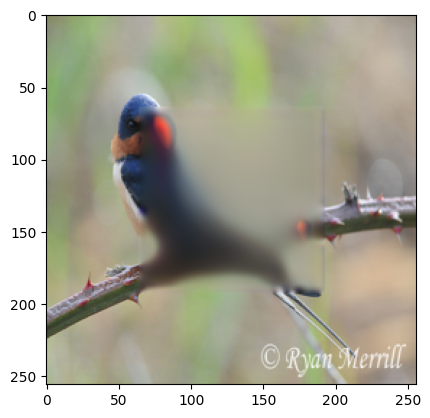

###################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################
Epoch 1/7
Batch 500/2352
TIM=5.019344806671143, RECON=0.05612638592720032, GAN_LOSS= 3.9713492393493652, TOTAL=0.06908842921257019


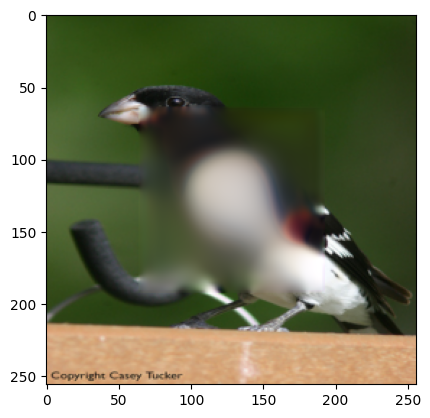

###################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################
Epoch 1/7
Batch 1000/2352
TIM=8.645651817321777, RECON=0.048130206763744354, GAN_LOSS= 3.9880528450012207, TOTAL=0.06475196778774261


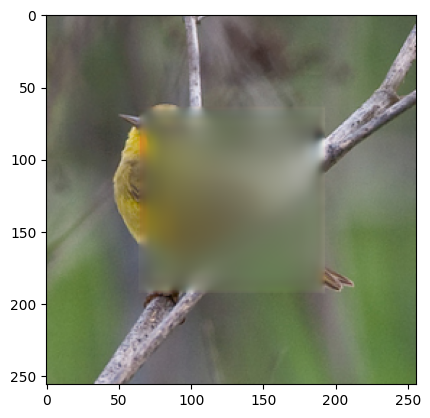

###################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################
Epoch 1/7
Batch 1500/2352
TIM=6.7011003494262695, RECON=0.060243260115385056, GAN_LOSS= 3.9736835956573486, TOTAL=0.07489173114299774


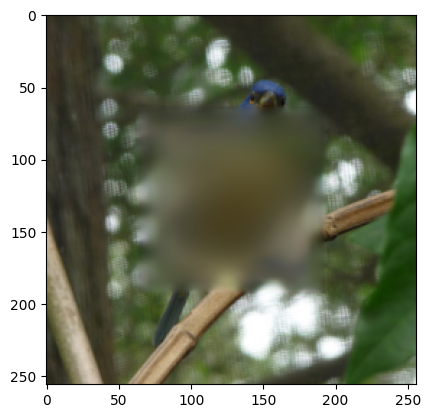

###################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################
Epoch 1/7
Batch 2000/2352
TIM=7.689342498779297, RECON=0.04789751395583153, GAN_LOSS= 4.141706466674805, TOTAL=0.06387026607990265


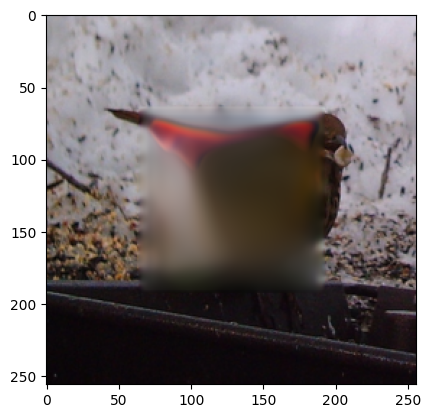

###############################################################################################################################################################################################################################################################################################################################################################
Epoch 2/7
Batch 0/2352
TIM=6.50209903717041, RECON=0.04931225627660751, GAN_LOSS= 4.029123783111572, TOTAL=0.06387260556221008


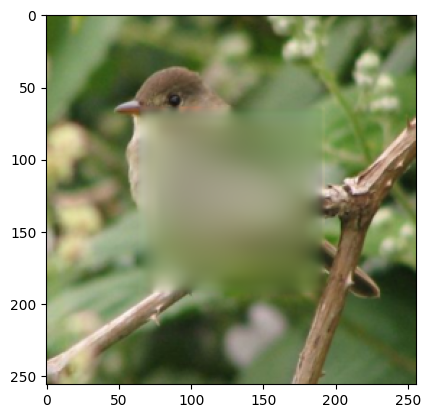

###################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################
Epoch 2/7
Batch 500/2352
TIM=8.118934631347656, RECON=0.04761847108602524, GAN_LOSS= 4.004817008972168, TOTAL=0.06374704092741013


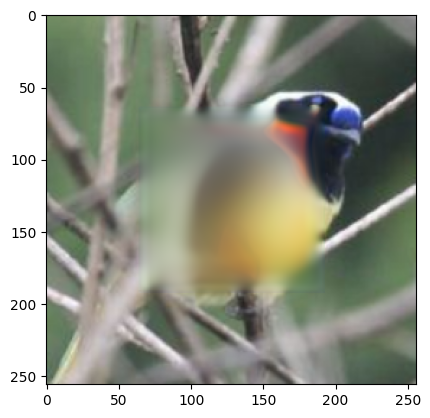

###################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################
Epoch 2/7
Batch 1000/2352
TIM=7.960030555725098, RECON=0.05306584760546684, GAN_LOSS= 4.013689994812012, TOTAL=0.06905326247215271


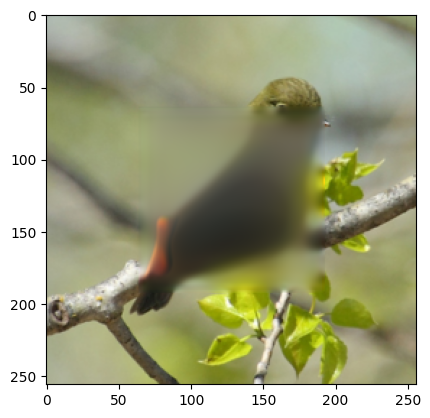

###################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################
Epoch 2/7
Batch 1500/2352
TIM=7.608776569366455, RECON=0.06540807336568832, GAN_LOSS= 4.0005598068237305, TOTAL=0.08101797103881836


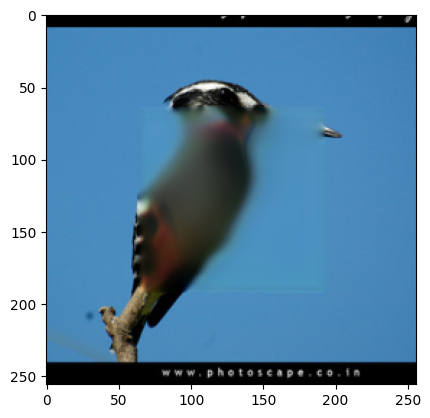

###################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################
Epoch 2/7
Batch 2000/2352
TIM=5.730802536010742, RECON=0.04851778969168663, GAN_LOSS= 3.9458255767822266, TOTAL=0.062140244990587234


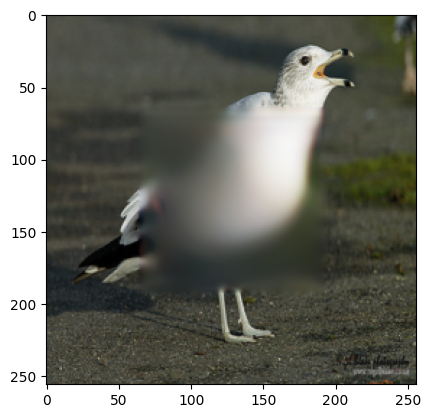

###############################################################################################################################################################################################################################################################################################################################################################
Epoch 3/7
Batch 0/2352
TIM=6.352126598358154, RECON=0.05074908211827278, GAN_LOSS= 4.015323162078857, TOTAL=0.06513185799121857


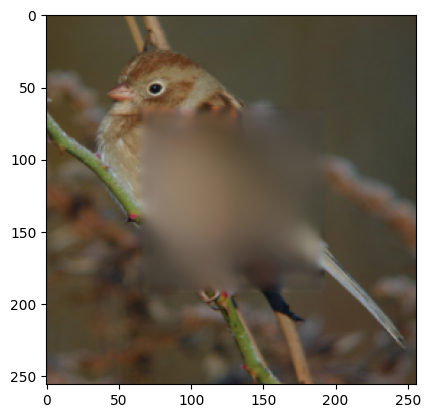

###################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################
Epoch 3/7
Batch 500/2352
TIM=7.81193208694458, RECON=0.0413912832736969, GAN_LOSS= 4.003355026245117, TOTAL=0.05720992758870125


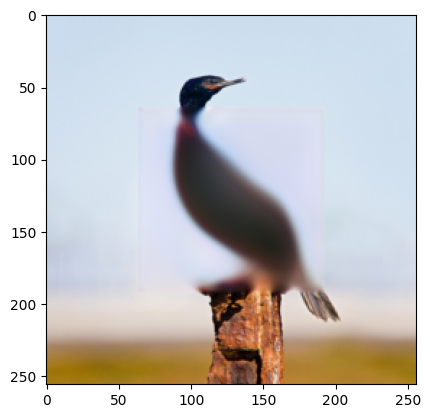

###################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################
Epoch 3/7
Batch 1000/2352
TIM=6.476057052612305, RECON=0.060397032648324966, GAN_LOSS= 4.00889778137207, TOTAL=0.07489088177680969


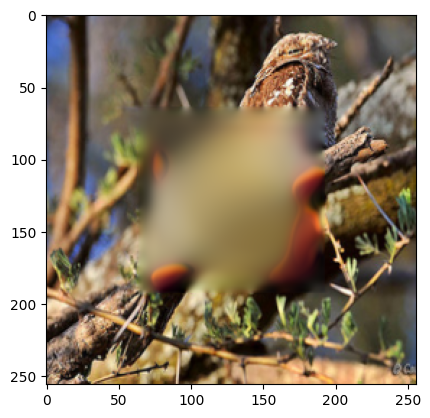

###################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################
Epoch 3/7
Batch 1500/2352
TIM=5.282132625579834, RECON=0.04655463621020317, GAN_LOSS= 4.012643814086914, TOTAL=0.059862058609724045


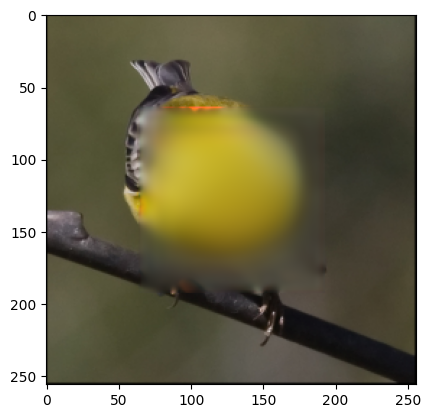

###################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################
Epoch 3/7
Batch 2000/2352
TIM=10.134952545166016, RECON=0.04422241821885109, GAN_LOSS= 4.020473957061768, TOTAL=0.06239832192659378


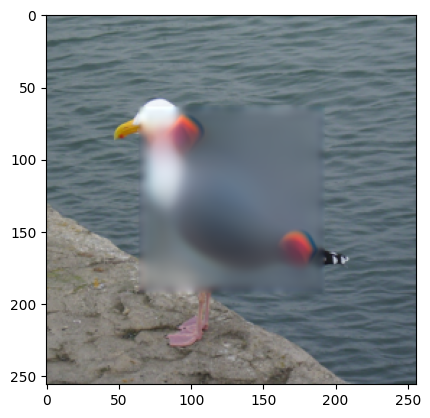

###############################################################################################################################################################################################################################################################################################################################################################
Epoch 4/7
Batch 0/2352
TIM=9.502280235290527, RECON=0.045466553419828415, GAN_LOSS= 3.9814505577087402, TOTAL=0.06293173134326935


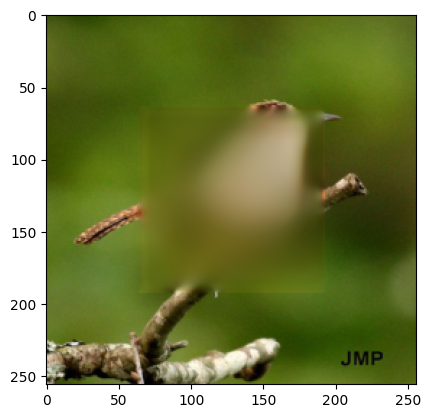

###################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################
Epoch 4/7
Batch 500/2352
TIM=7.30458927154541, RECON=0.043507713824510574, GAN_LOSS= 4.007905960083008, TOTAL=0.058828115463256836


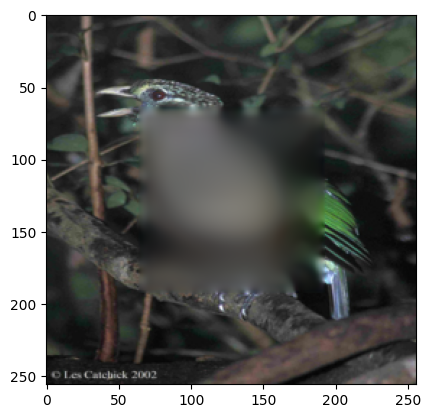

###################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################
Epoch 4/7
Batch 1000/2352
TIM=5.292797565460205, RECON=0.057824742048978806, GAN_LOSS= 4.005377292633057, TOTAL=0.07112829387187958


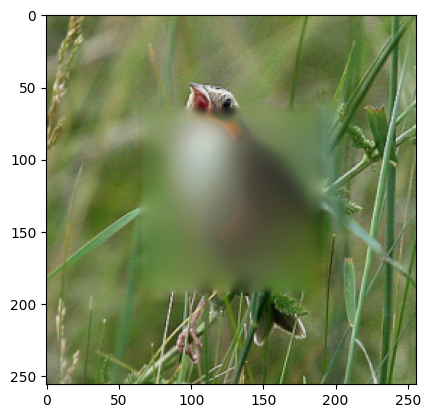

###################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################
Epoch 4/7
Batch 1500/2352
TIM=6.190936088562012, RECON=0.05190200358629227, GAN_LOSS= 3.980429172515869, TOTAL=0.06605380028486252


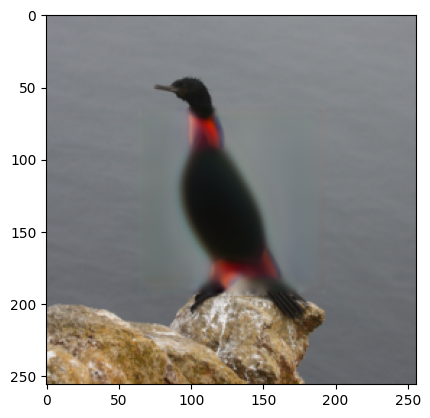

###################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################
Epoch 4/7
Batch 2000/2352
TIM=8.416669845581055, RECON=0.04767325893044472, GAN_LOSS= 4.001243591308594, TOTAL=0.06409242004156113


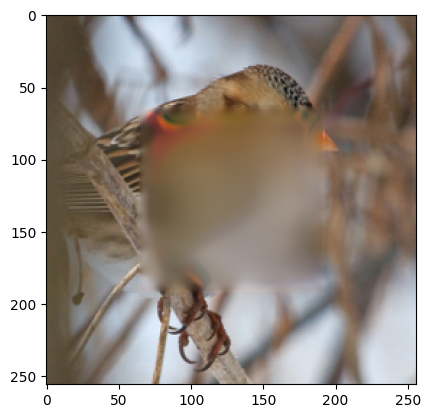

###############################################################################################################################################################################################################################################################################################################################################################
Epoch 5/7
Batch 0/2352
TIM=3.6410233974456787, RECON=0.049016181379556656, GAN_LOSS= 4.014298439025879, TOTAL=0.06068580225110054


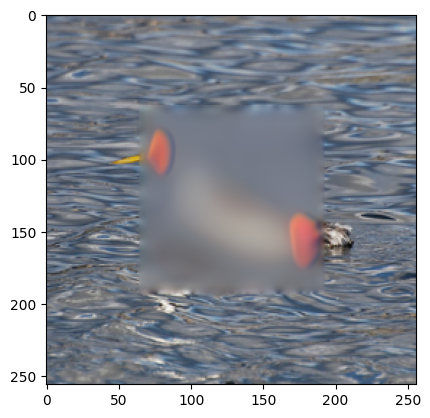

###################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################
Epoch 5/7
Batch 500/2352
TIM=8.73080062866211, RECON=0.05813591182231903, GAN_LOSS= 4.008536338806152, TOTAL=0.07488378137350082


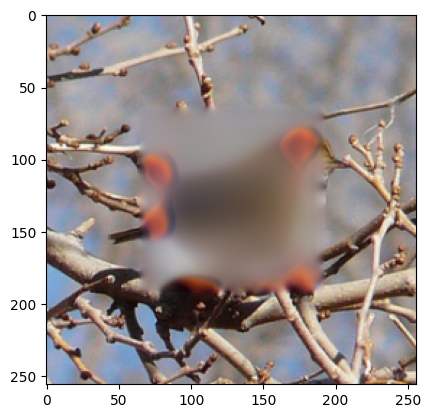

###################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################
Epoch 5/7
Batch 1000/2352
TIM=6.027678489685059, RECON=0.04731999337673187, GAN_LOSS= 3.9820027351379395, TOTAL=0.06131167709827423


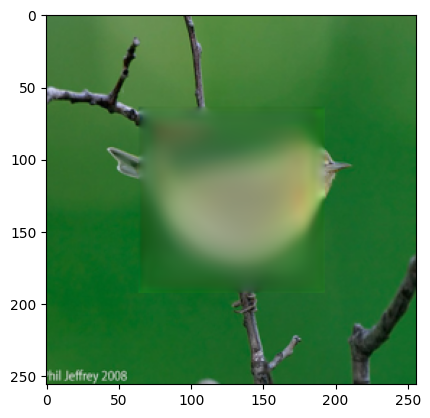

###################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################
Epoch 5/7
Batch 1500/2352
TIM=7.1991190910339355, RECON=0.042431339621543884, GAN_LOSS= 4.001460552215576, TOTAL=0.057633381336927414


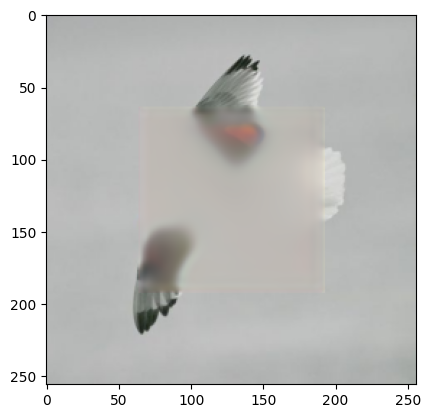

###################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################
Epoch 5/7
Batch 2000/2352
TIM=6.548882484436035, RECON=0.05213058739900589, GAN_LOSS= 3.988184928894043, TOTAL=0.06665583699941635


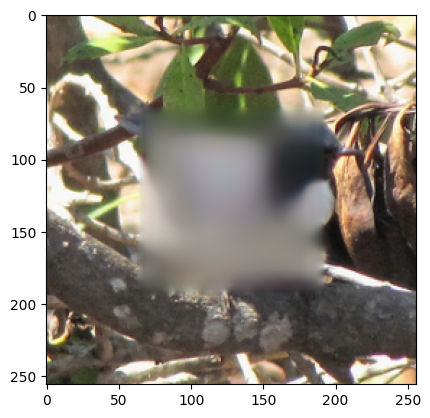

###############################################################################################################################################################################################################################################################################################################################################################
Epoch 6/7
Batch 0/2352
TIM=10.568633079528809, RECON=0.039378151297569275, GAN_LOSS= 4.0084075927734375, TOTAL=0.05796360224485397


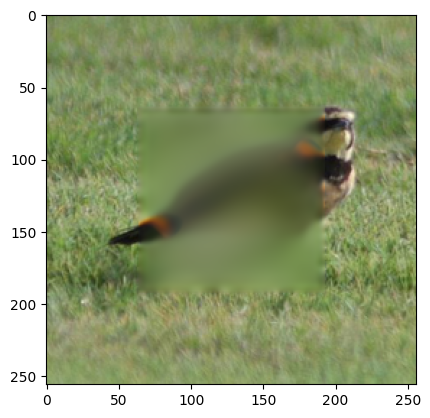

###################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################
Epoch 6/7
Batch 500/2352
TIM=8.428689956665039, RECON=0.05463924631476402, GAN_LOSS= 3.9691672325134277, TOTAL=0.07100626826286316


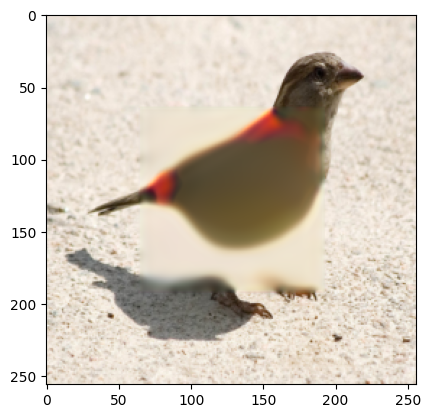

###################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################
Epoch 6/7
Batch 1000/2352
TIM=7.225441932678223, RECON=0.03707359731197357, GAN_LOSS= 4.005709648132324, TOTAL=0.052310459315776825


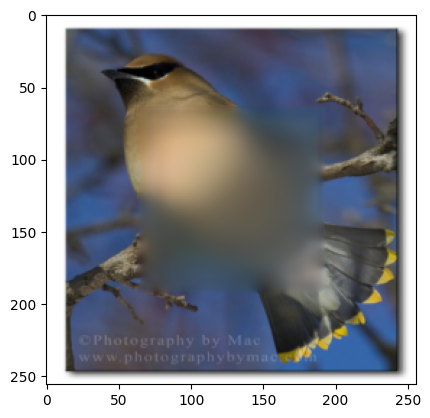

###################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################
Epoch 6/7
Batch 1500/2352
TIM=7.646674156188965, RECON=0.04821210354566574, GAN_LOSS= 3.999178409576416, TOTAL=0.06385713070631027


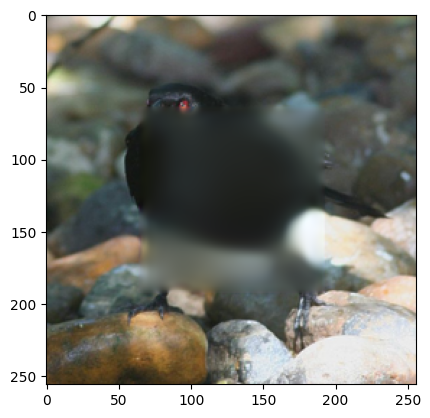

###################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################
Epoch 6/7
Batch 2000/2352
TIM=10.336505889892578, RECON=0.04724898561835289, GAN_LOSS= 3.9748642444610596, TOTAL=0.06553521752357483


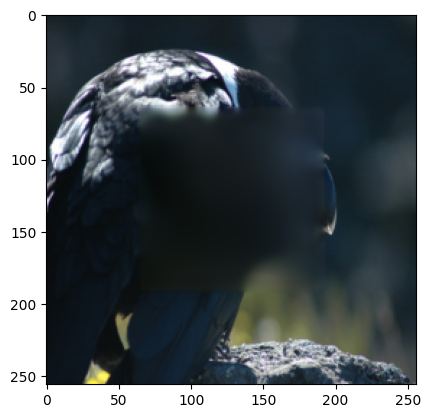

###############################################################################################################################################################################################################################################################################################################################################################CPU times: user 4h 39min 51s, sys: 22min 36s, total: 5h 2min 28s
Wall time: 4h 54min 40s


In [28]:
%%time
for epoch in range(NUM_EPOCHS):
    train_step = 0
    num_steps = len(dataloader)
    while(train_step < num_steps):
        
        imgs, captions, cap_lens, cls_ids, cap_texts = get_data(dataloader)
        hidden = text_encoder.init_hidden(BATCH_SIZE)
    
        words_embs, sent_emb = text_encoder(captions, cap_lens, hidden)
        words_embs, sent_emb = words_embs.detach(), sent_emb.detach()
    
        
        text_mask = (captions == 0)
    
        num_words = words_embs.size(2)
        if text_mask.size(1) > num_words:
            text_mask = text_mask[:, :num_words]
        text_mask = text_mask.to(device)
    
        mask = get_mask()
        masked = imgs * (1. - mask)
        # masked = masked.to(device)
    
        noise = noise.data.normal_(0, 1).to(device)
        
        coarse_result_t, refine_result_t, attn_loss = g_model(masked, mask, noise, sent_emb, words_embs, text_mask)
        
        region_features, cnn_code = image_encoder(refine_result_t.clone())
    
        w_loss0, w_loss1, _ = words_loss(region_features, words_embs, match_labels, cap_lens, cls_ids, BATCH_SIZE , torch.cuda.is_available())
        w_loss = (w_loss0 + w_loss1) * 1.0
        
        s_loss0, s_loss1 = sent_loss(cnn_code, sent_emb, match_labels, cls_ids, BATCH_SIZE, torch.cuda.is_available())
        s_loss = (s_loss0 + s_loss1) * 1.0
        
        matching_loss = w_loss + s_loss
        
        pg_loss_t, pd_loss_t = calc_gan_loss(d_model, refine_result_t, imgs)
        
        recon_loss_t =  get_recon_loss(mask, imgs, coarse_result_t,L1Loss) + get_recon_loss(mask, imgs, refine_result_t, L1Loss) + L1Loss(refine_result_t * attn_loss, imgs * attn_loss)         
        gan_loss_t = pg_loss_t
        
        # total_loss_t = 1*recon_loss_t #+ 0.001*matching_loss #+ 0.002*gan_loss_t
        # total_loss_t = 0.001*matching_loss + recon_loss_t

        total_loss_t = 1*recon_loss_t + 0.001*matching_loss + 0.002*gan_loss_t.detach().clone()
        
        # total_loss_t = gan_loss_t


        d_optimizer.zero_grad()
        pd_loss_t.backward(retain_graph=True)   ### BACKWARD on Discriminator
        d_optimizer.step()
        
        g_optimizer.zero_grad()
        total_loss_t.backward()  ### BACKWARD on Generator
        g_optimizer.step()        
        
    
        if(train_step % 500 ==0):
            print()
            print(f"Epoch {epoch}/{NUM_EPOCHS}\nBatch {train_step}/{num_steps}")
            print(f"TIM={matching_loss}, RECON={recon_loss_t}, GAN_LOSS= {gan_loss_t}, TOTAL={total_loss_t}")
            # print(f"RECON={recon_loss_t}, TOTAL={total_loss_t}")

            fin_img = refine_result_t[0].cpu().detach().numpy().transpose(1,2,0)
            plt.imshow(fin_img)
            plt.show()
        else:
            print("#",end="")

        train_step += 1

In [29]:
torch.save(g_model.state_dict(), '/kaggle/working/GenWts')
torch.save(d_model.state_dict(),'/kaggle/working/DiscWts' )

In [30]:
# imgs, captions, cap_lens, cls_ids, cap_texts = get_data(dataloader)

In [31]:
# hidden = text_encoder.init_hidden(BATCH_SIZE)

# words_embs, sent_emb = text_encoder(captions, cap_lens, hidden)
# words_embs, sent_emb = words_embs.detach(), sent_emb.detach()

In [32]:
# text_mask = (captions == 0)

In [33]:
# num_words = words_embs.size(2)
# if text_mask.size(1) > num_words:
#     text_mask = text_mask[:, :num_words]

In [34]:
# img = imgs[-1]
# mask = get_mask()
# masked = img * (1. - mask)
# masked.shape

In [35]:
# noise = noise.data.normal_(0, 1)

In [36]:
# g_model = InpaintNet().to(device)

In [37]:
# d_model = PatchDiscriminator().to(device)

In [38]:
# coarse_result_t, refine_result_t, attn_loss = g_model(masked.to(device), mask.to(device), noise.to(device), sent_emb.to(device), words_embs.to(device), text_mask.to(device))

In [39]:
# region_features, cnn_code = image_encoder(refine_result_t)

In [40]:
# w_loss0, w_loss1, _ = words_loss(region_features, words_embs, match_labels, cap_lens, cls_ids, BATCH_SIZE , torch.cuda.is_available())
# w_loss = (w_loss0 + w_loss1) * 1.0

In [41]:
# s_loss0, s_loss1 = sent_loss(cnn_code, sent_emb, match_labels, cls_ids, BATCH_SIZE, torch.cuda.is_available())
# s_loss = (s_loss0 + s_loss1) * 1.0

In [42]:
# matching_loss = w_loss + s_loss

In [43]:
# pg_loss_t, pd_loss_t = calc_gan_loss(d_model, refine_result_t, imgs)

In [44]:
# recon_loss_t = L1Loss(coarse_result_t, img) + L1Loss(refine_result_t, img) + L1Loss(refine_result_t * attn_loss, img * attn_loss)  ### RECON LOSS AND TGA HERE
# gan_loss_t = pg_loss_t

# total_loss_t = 1*recon_loss_t + 0.002*gan_loss_t + 0.001*matching_loss